In [137]:
# This is a simple analysis using the VAR method to regress AIL_DEMAND using temperature values and pool price 
# as explanatory variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split

In [169]:
# Append data from both sheets into one dataframe
filepath1 = 'cleaned data/AIL and Pool Price with Temperature (2010-2020) sheet 1.csv'
filepath2 = 'cleaned data/AIL and Pool Price with Temperature (2010-2020) sheet 2.csv'
df1 = pd.read_csv(filepath1, parse_dates=True)
df2 = pd.read_csv(filepath2)
df = df1.append(df2)
#print(df.shape)  # should be (96432, 10)
df.tail()

,BEGIN_DATE_GMT,BEGIN_TIME_GMT,DATE,HE,POOL_PRICE,AIL_DEMAND,EDMONTON_TEMP,CALGARY_TEMP,FORT_MCMURRAY_TEMP,LETHBRIDGE_TEMP
31428,2021-01-01 02:00:00,02:00:00,2020-12-31,20,33.13,10581,-3,-6.6,-11.2,-1.3
31429,2021-01-01 03:00:00,03:00:00,2020-12-31,21,32.62,10385,-3,-4.1,-10.9,0.6
31430,2021-01-01 04:00:00,04:00:00,2020-12-31,22,28.86,10209,-5,-4.2,-10.3,0.6
31431,2021-01-01 05:00:00,05:00:00,2020-12-31,23,31.28,10055,-4,-6.1,-9.6,1.0
31432,2021-01-01 06:00:00,06:00:00,2020-12-31,24,31.27,9858,-5,-3.7,-8.9,1.1


object


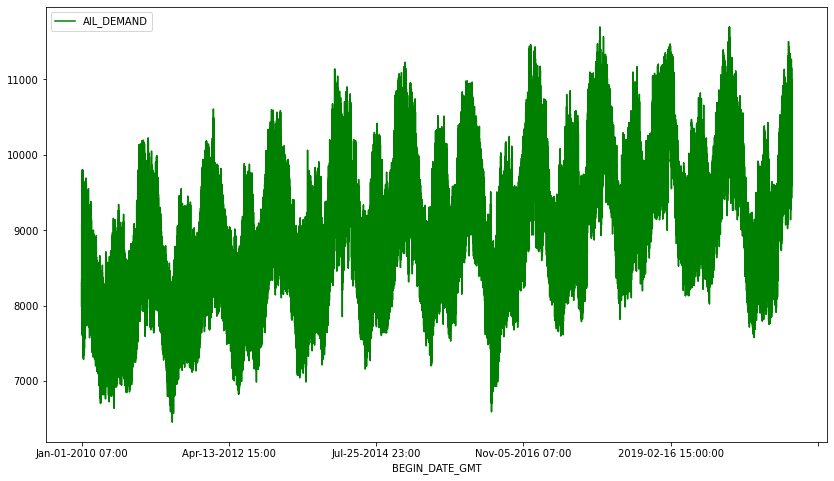

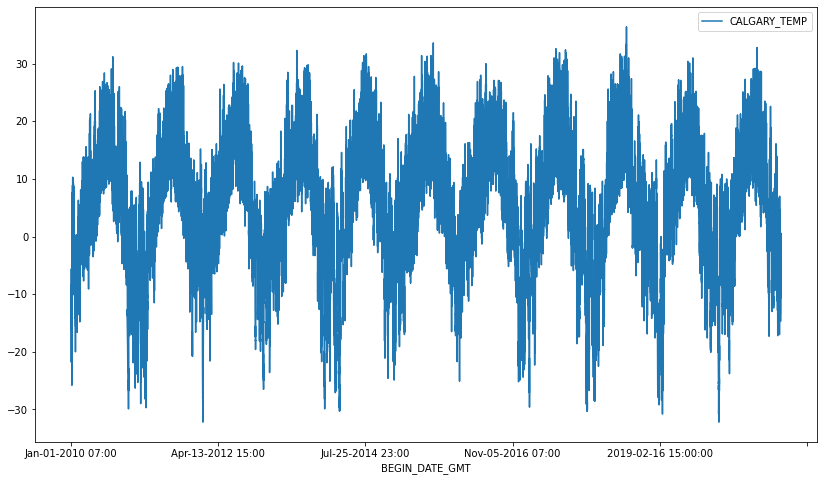

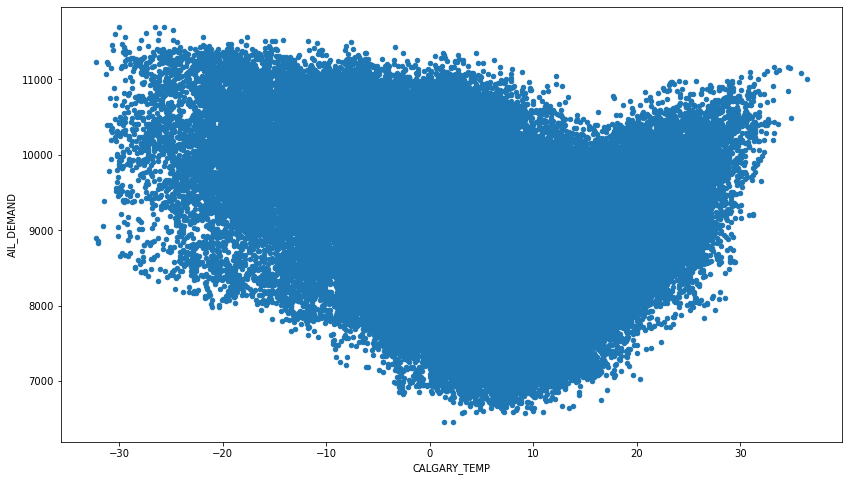

In [157]:
# Initial Plots (as an easy test for stationarity)
df.plot(figsize= (14,8), x='BEGIN_DATE_GMT', y='AIL_DEMAND', color='green')
df.plot(figsize= (14,8),x='BEGIN_DATE_GMT', y='CALGARY_TEMP')
df.plot.scatter(figsize= (14,8),x='CALGARY_TEMP', y='AIL_DEMAND')


In [107]:
# Perform Augment Dicky Fuller test as a thorough test for stationarity
# adapted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
def adfuller_test(series, name='', signif=0.05,  verbose=False):
    
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        
df_no_dates = df.drop(columns=['BEGIN_DATE_GMT', 'DATE','BEGIN_TIME_GMT', 'HE'])       
    
for name, column in df_no_dates.items():
    adfuller_test(column, name=column.name)
    print('\n')
        

#adfuller_test(df['AIL_DEMAND'], df['AIL_DEMAND'].name)
#adfuller_test(df['CALGARY_TEMP'], df['CALGARY_TEMP'].name)

        
# For now all series are stationary so no need for any transformations 

    Augmented Dickey-Fuller Test on "POOL_PRICE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.0632
 No. Lags Chosen       = 67
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AIL_DEMAND" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.153
 No. Lags Chosen       = 67
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EDMONTON_TEMP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

In [160]:
# Test for causation with Granger Causality Test
# If a given p-value is < significance level (0.05), then, the series x causes the series y in df[[x,y]]

res = grangercausalitytests(df[["AIL_DEMAND", "CALGARY_TEMP"]], maxlag=5)  

print("\n\n ==================================== \n")

res = grangercausalitytests(df[["AIL_DEMAND", "POOL_PRICE"]], maxlag=5)

# Results : all p-values < 0.05, meaning pool price and temperature both cause AIL demand


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=868.5599, p=0.0000  , df_denom=96428, df_num=1
ssr based chi2 test:   chi2=868.5870, p=0.0000  , df=1
likelihood ratio test: chi2=864.6985, p=0.0000  , df=1
parameter F test:         F=868.5599, p=0.0000  , df_denom=96428, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1435.7610, p=0.0000  , df_denom=96425, df_num=2
ssr based chi2 test:   chi2=2871.6710, p=0.0000  , df=2
likelihood ratio test: chi2=2829.7424, p=0.0000  , df=2
parameter F test:         F=1435.7610, p=0.0000  , df_denom=96425, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1240.8542, p=0.0000  , df_denom=96422, df_num=3
ssr based chi2 test:   chi2=3722.8328, p=0.0000  , df=3
likelihood ratio test: chi2=3652.7668, p=0.0000  , df=3
parameter F test:         F=1240.8542, p=0.0000  , df_denom=96422, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=

In [109]:
 # Perform Johanson's Cointegration Test to check for a statistically significant relationship between variables
# adapted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/ 
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Significant  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_no_dates)

# Result : 

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
POOL_PRICE ::  22633.95  > 83.9383   =>   True
AIL_DEMAND ::  14595.82  > 60.0627   =>   True
EDMONTON_TEMP ::  8013.95   > 40.1749   =>   True
CALGARY_TEMP ::  2835.66   > 24.2761   =>   True
FORT_MCMURRAY_TEMP ::  449.51    > 12.3212   =>   True
LETHBRIDGE_TEMP ::  10.78     > 4.1296    =>   True


In [170]:
# Split data into train (80%) and test (20%) partitions
df_no_dates = df.drop(columns=['DATE','BEGIN_TIME_GMT', 'HE'])  
df_train, df_test = train_test_split(df_no_dates, test_size=0.2)

print(df_train.shape) 
print(df_test.shape)

(77145, 7)
(19287, 7)


In [171]:
# Find AIC to select order of the VAR model

model = VAR(np.asarray(df_train))
aic_values = {}
bic_values = {}
fpe_values = {}
hqic_values = {}
for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    aic_values[i] = result.aic 
    bic_values[i] = result.bic
    fpe_values[i] = result.fpe
    hqic_values[i] = result.hqic
    
print("Min AIC is in lag ", min(aic_values))
print("Min BIC is in lag ", min(bic_values))

# This method also finds the lowest AIC/BIC
# x = model.select_order(maxlags=12)
# x.summary()

# Results : optimal lag is order 1 according to explicit calculation and 0 according to model.select_order method

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [154]:
# Train model
model_fitted = model.fit(1) #fit with lag order 1
model_fitted.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Feb, 2021
Time:                     22:36:47
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    36.3582
Nobs:                     77144.0    HQIC:                   36.3548
Log likelihood:      -2.05895e+06    FPE:                6.13756e+15
AIC:                      36.3532    Det(Omega_mle):     6.13422e+15
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        47.332351         4.378047           10.811           0.000
L1.y1         0.002708         0.003643            0.743           0.457
L1.y2         0.000292         0.000482            0.606           0.544
L1.y3         0.100467

In [161]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

1


In [162]:
# autocorrelation function
# model_fitted.plot_acorr()

In [140]:
# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

array([[ 3.584e+01,  9.101e+03, -1.400e+01, -1.140e+01, -8.000e+00,
        -1.450e+01]])

In [146]:
# Forecast
number_obs = 10
fc = model_fitted.forecast(y=forecast_input, steps=number_obs)
df_forecast = pd.DataFrame(fc, index=df_no_dates.index[-nobs:], columns=df_no_dates.columns + '_1d')
df_forecast

,POOL_PRICE_2d,AIL_DEMAND_2d,EDMONTON_TEMP_2d,CALGARY_TEMP_2d,FORT_MCMURRAY_TEMP_2d,LETHBRIDGE_TEMP_2d
31423,50.592319,9064.529775,4.448017,4.866770,1.438357,5.755232
31424,49.864874,9064.200520,4.471347,4.942868,1.577086,5.827500
31425,49.858009,9064.287892,4.469628,4.940767,1.574634,5.825367
31426,49.858067,9064.287556,4.469639,4.940780,1.574643,5.825379
31427,49.858068,9064.287554,4.469639,4.940780,1.574643,5.825379
31428,49.858068,9064.287554,4.469639,4.940780,1.574643,5.825379
31429,49.858068,9064.287554,4.469639,4.940780,1.574643,5.825379
31430,49.858068,9064.287554,4.469639,4.940780,1.574643,5.825379
31431,49.858068,9064.287554,4.469639,4.940780,1.574643,5.825379
31432,49.858068,9064.287554,4.469639,4.940780,1.574643,5.825379
